In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import os
import sys
import seaborn as sns
os.environ["CODE_REPO_PATH"]="/home/haokunliu/past-interaction-learning"
os.environ["SERVER"]='dsi'
os.environ["PORT"]='6379'
code_repo_path = os.environ.get("CODE_REPO_PATH")

MODEL_ORDERING = {
    'RoBERTa': 0,
    'few_shot_all': 1,
    'no_update': 2,
    'default': 3,
    'knn': 4,
    'knn_separate_steps': 5,
    'filter_and_weight': 6 
}

In [56]:
import json
def load_jsonl(file_path):
# Replace 'path_to_file.jsonl' with the actual file path
# Create an empty list to hold JSON objects
    json_objects = []

    # Open the .jsonl file and read lines
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Parse the JSON object and add to the list
            json_object = json.loads(line.strip())
            json_objects.append(json_object)

    # Now `json_objects` holds a list of dictionaries
    # You can process your json objects here
    return json_objects

def filter_dictionaries(dict_list, filter):
    filtered_list = [d for d in dict_list if all(d.get(key) == value for key, value in filter.items())]
    return filtered_list

def load_results(model_name, results_path):
    roberta = load_jsonl(f'{results_path}/RoBERTa.jsonl')
    few_shot_all = load_jsonl(f'{results_path}/few_shot_{model_name}.jsonl')
    no_update = load_jsonl(f'{results_path}/no_update_{model_name}.jsonl')
    default = load_jsonl(f'{results_path}/default_{model_name}.jsonl')
    knn = load_jsonl(f'{results_path}/knn_{model_name}.jsonl')
    knn_separate_steps = load_jsonl(f'{results_path}/knn_separate_steps_{model_name}.jsonl')
    filter_and_weight = load_jsonl(f'{results_path}/filter_and_weight_{model_name}.jsonl')
    return [roberta,
            few_shot_all,
            no_update,
            default,
            knn,
            knn_separate_steps,
            filter_and_weight]

def preprocess_results(results, method):
    if method == 'RoBERTa':
        return results[:-1]
    if method == 'few_shot_all':
        few_shot = filter_dictionaries(results,{'inference_method':'few_shot'})
        zero_shot = filter_dictionaries(results,{'inference_method':'zero_shot'})
        return (zero_shot, few_shot)
    if method == 'no_update':
        return results
    if method in ['default','knn','knn_separate_steps','filter_and_weight']:
        ours_hyp_3 = filter_dictionaries(results,{'hyp_size':3})
        ours_hyp_20 = filter_dictionaries(results,{'hyp_size':20})
        return (ours_hyp_3,ours_hyp_20)
    
    raise ValueError(f"Invalid method: {method}")
    
def get_result_array(results):
    method = results[0]['inference_method']
    out = None

    if method in ['RoBERTa','no_update','default','knn','knn_separate_steps','filter_and_weight']:
        out = [entry['acc'] for entry in results]
    if method in ['zero_shot','few_shot']:
        out = [results[0]['acc']] * 5
    if out is not None:
        return np.array(out) * 100
    
    raise ValueError(f"Invalid method: {method}")

# Old version just for reference
# def get_result_array(results):
#     method = results[0]['inference_method']
#     out = None

#     if method in ['RoBERTa','default','knn','knn_separate_steps','filter_and_weight']:
#         out = [entry['acc'] for entry in results]
#     if method in ['zero_shot','few_shot']:
#         out = [results[0]['acc']] * 5
#     if method in ['no_update']:
#         out = [entry['acc'] for entry in results]
#         for i in range(len(out)):
#             if out[i] == 0:
#                 out[i] = out[i-1]
                
#     if out is not None:
#         return np.array(out) * 100
    
#     raise ValueError(f"Invalid method: {method}")

In [57]:
def get_results_by_task(model_name, task):
    task_results_dict = {}
    results_path = f'{code_repo_path}/results_final'
    task_filter = {'task': task}
    train_sizes = [10,25,50,100,200]
    results_by_method = load_results(model_name, results_path)
    for idx in range(len(results_by_method)):
        results_by_method[idx] = filter_dictionaries(results_by_method[idx],task_filter)

    roberta = preprocess_results(results_by_method[MODEL_ORDERING['RoBERTa']],'RoBERTa')
    zero_shot, few_shot = preprocess_results(results_by_method[MODEL_ORDERING['few_shot_all']],'few_shot_all')
    no_update = preprocess_results(results_by_method[MODEL_ORDERING['no_update']],'no_update')
    task_results_dict.update({
        'RoBERTa': get_result_array(roberta),
        'Zero shot': get_result_array(zero_shot),
        'Few shot': get_result_array(few_shot),
        'No updates': get_result_array(no_update)
    })

    # Process ours
    ours_all = results_by_method[MODEL_ORDERING['default']:]
    ours_hyp_3 = [preprocess_results(ours,ours[0]['inference_method'])[0] for ours in ours_all]
    ours_hyp_20 = [preprocess_results(ours,ours[0]['inference_method'])[1] for ours in ours_all]
    ours_hyp_3_array = np.array([get_result_array(method_hyp_3) for method_hyp_3 in ours_hyp_3])
    ours_hyp_20_array = np.array([get_result_array(method_hyp_20) for method_hyp_20 in ours_hyp_20])
    
    ours_hyp_3_best = np.max(ours_hyp_3_array,axis=0)
    ours_hyp_20_best = np.max(ours_hyp_20_array,axis=0)

    task_results_dict.update({
        'hyp_3 (best)': ours_hyp_3_best,
        'hyp_20 (best)': ours_hyp_20_best
    })

    return task_results_dict


In [103]:
import matplotlib.pyplot as plt

def line_chart_by_model(model):
    shoe = get_results_by_task(model, 'shoe')
    hotel = get_results_by_task(model, 'hotel_reviews')
    headline = get_results_by_task(model, 'headline_binary')
    retweet = get_results_by_task(model, 'retweet')
    all_results_list = [[shoe, hotel], [headline, retweet]]
    dataset_names = [["Shoe Sales", "Deceptive Reviews"], ["Headline", "Retweet"]]
    train_sizes = [10, 25, 50, 100, 200]
    markers = ['o','^','^','v','*','*']
    linestyle = '-'
    colors = ['#FF9ABF','#FF6A6A','#E8DE61','#6DC500','#7A789A','#4AB9B9']
    font = {'size': 40}

    plt.rc('font', **font)

    fig, axes = plt.subplots(2, 2, figsize=(30, 30), sharex=True)
    for row in range(2):
        for col in range(2):
            data_to_plot = all_results_list[row][col]
            for idx, method in enumerate(data_to_plot.keys()):
                axes[row, col].plot(train_sizes,
                                    data_to_plot[method],
                                    label=method,
                                    linewidth=6,
                                    linestyle=linestyle,
                                    marker=markers[idx],  # Add markers
                                    markersize=25,
                                    color=colors[idx])  # Adjust marker size
                axes[row, col].set_ylabel("Accuracy", fontsize=40)
                axes[row, col].set_xlabel("Train size", fontsize=40)
                axes[row, col].set_title(dataset_names[row][col])
                axes[row, col].tick_params(axis='both', which='major', labelsize=40)

    model_plot_name = {
        'Mixtral-8x7B': 'Mixtral-8x7B',
        'claude_2': 'Claude-2.1',
        'turbo35_0613': 'GPT-3.5'
    }

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=6, title='Methods')
    plt.suptitle(f"{model_plot_name[model]} performance for all datasets")
    plt.tight_layout()
    plt.show()
    model_file_names = {
        'Mixtral-8x7B': 'mixtral_line_chart',
        'claude_2':' claude_line_chart',
        'turbo35_0613': 'gpt_line_chart'
    }
    fig.savefig(f'{code_repo_path}/figures/{model_file_names[model]}.pdf')


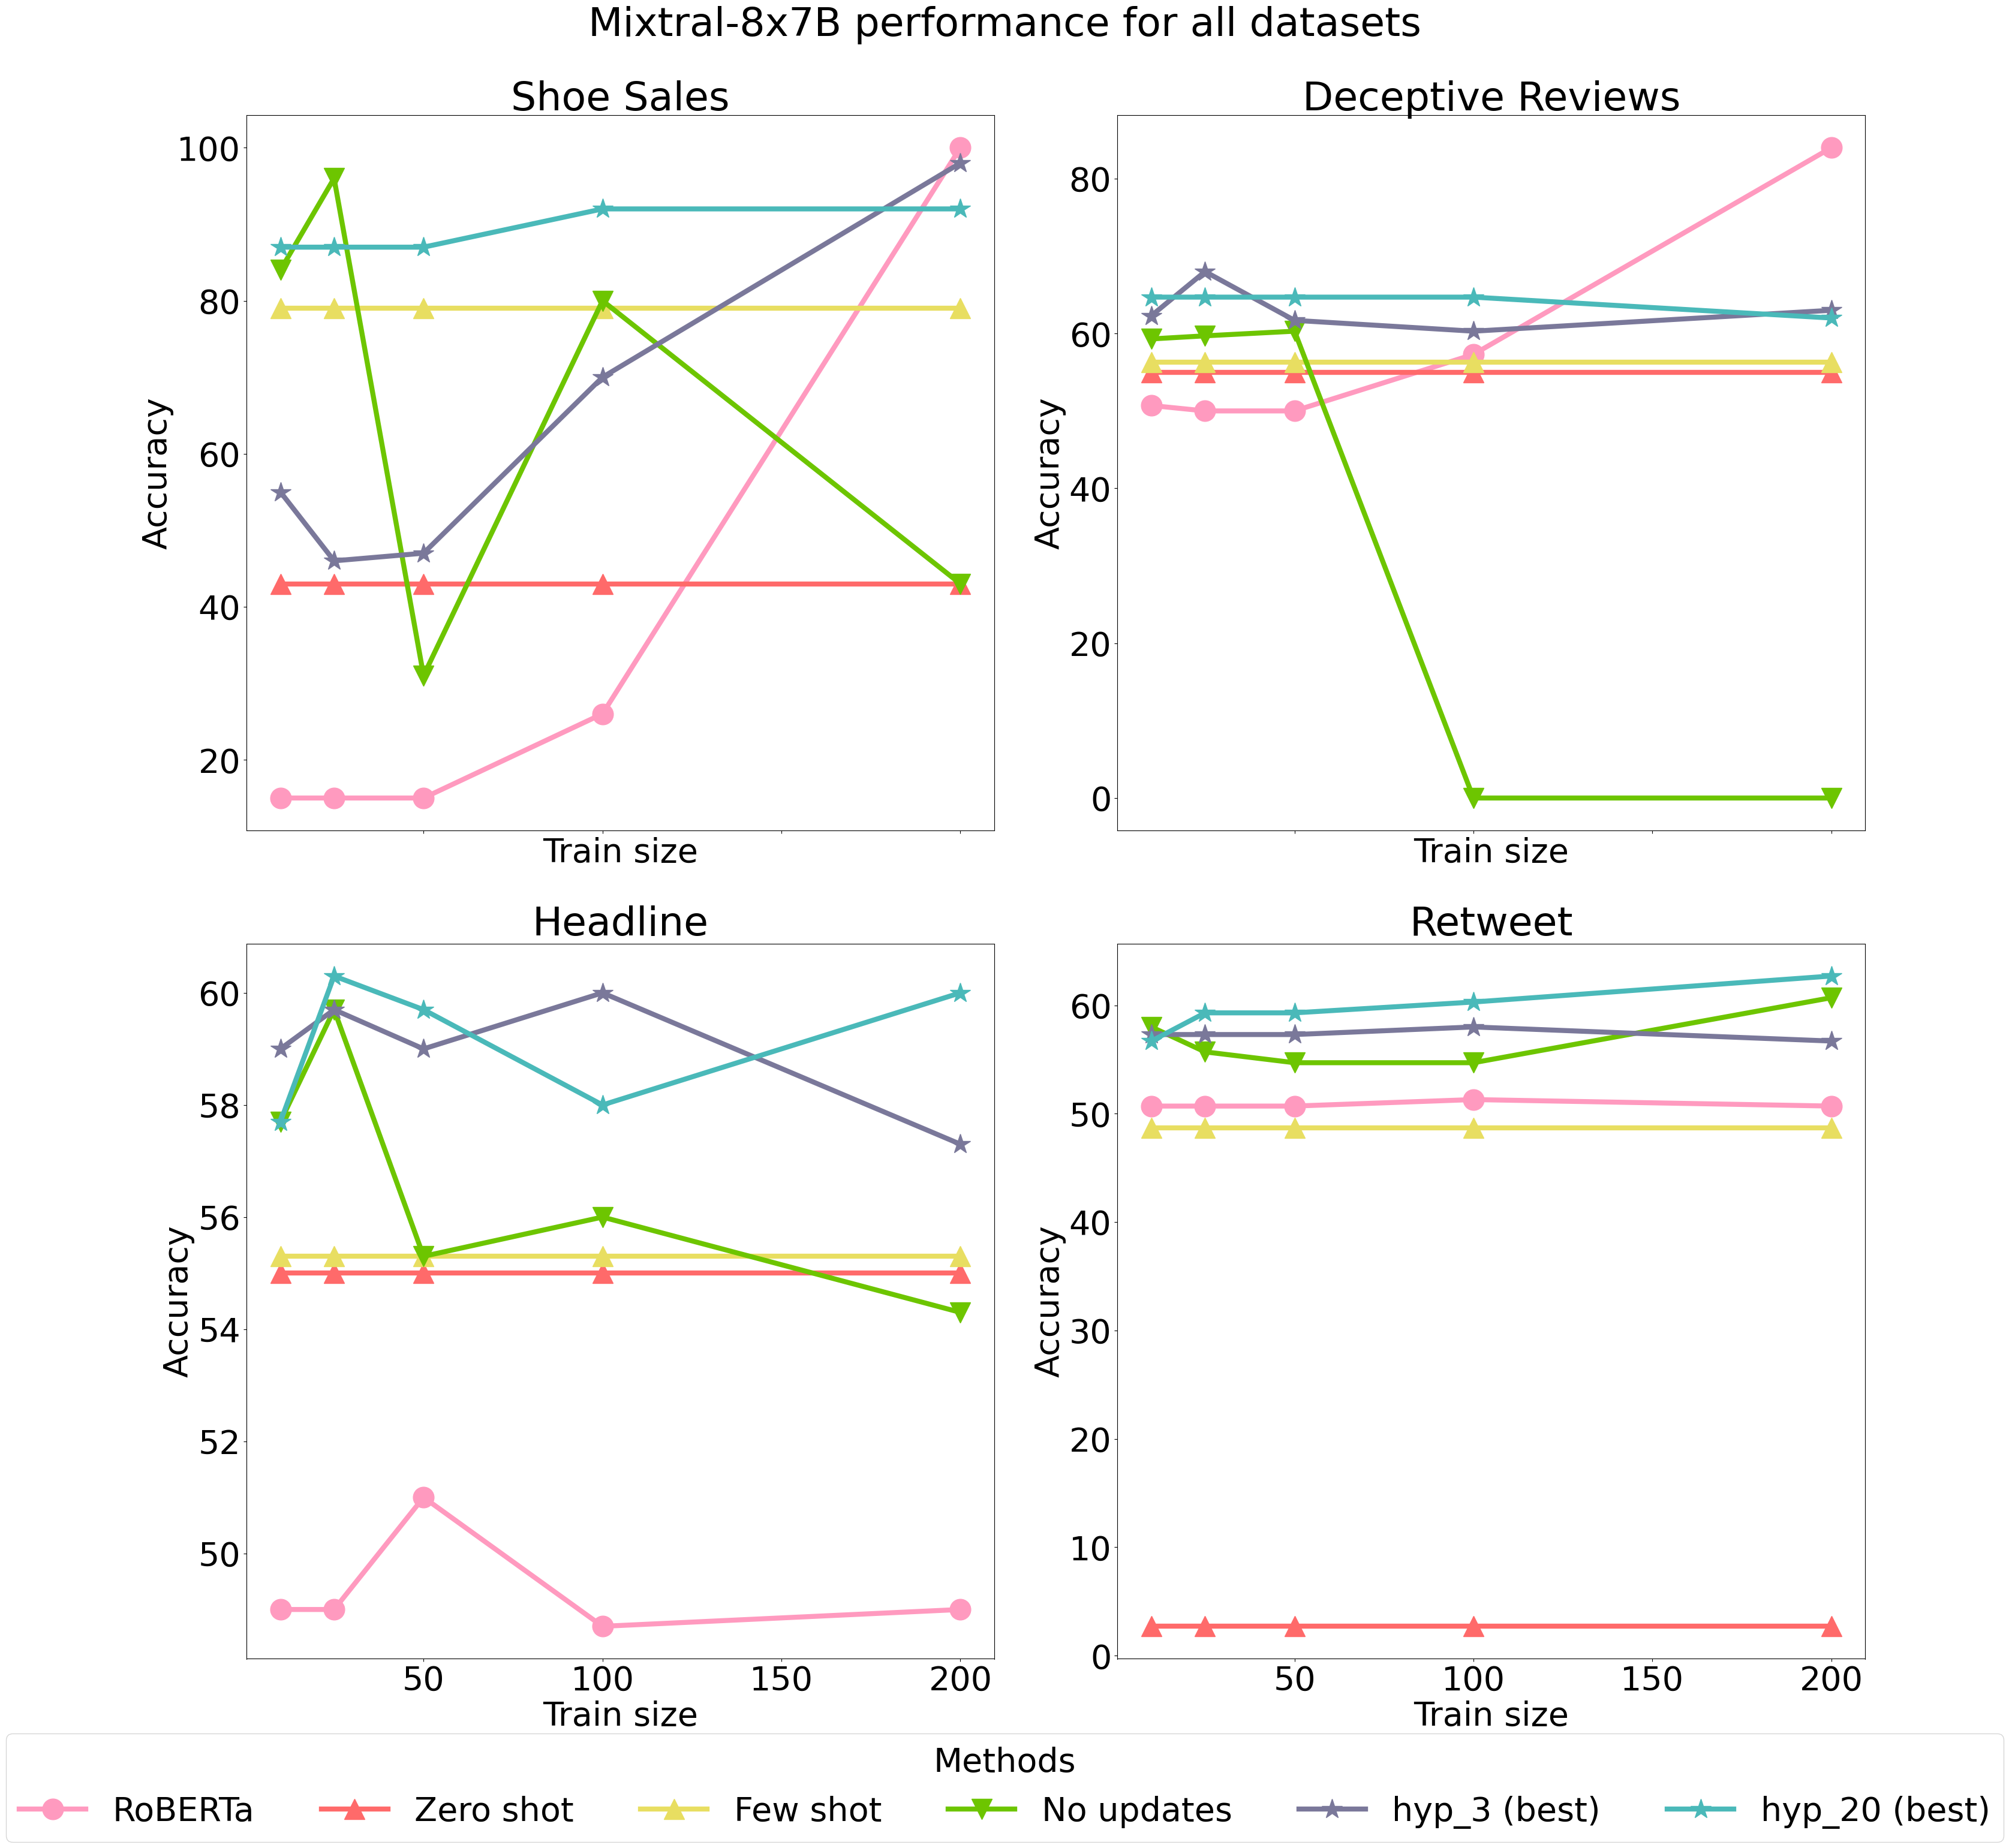

In [105]:
line_chart_by_model('Mixtral-8x7B')

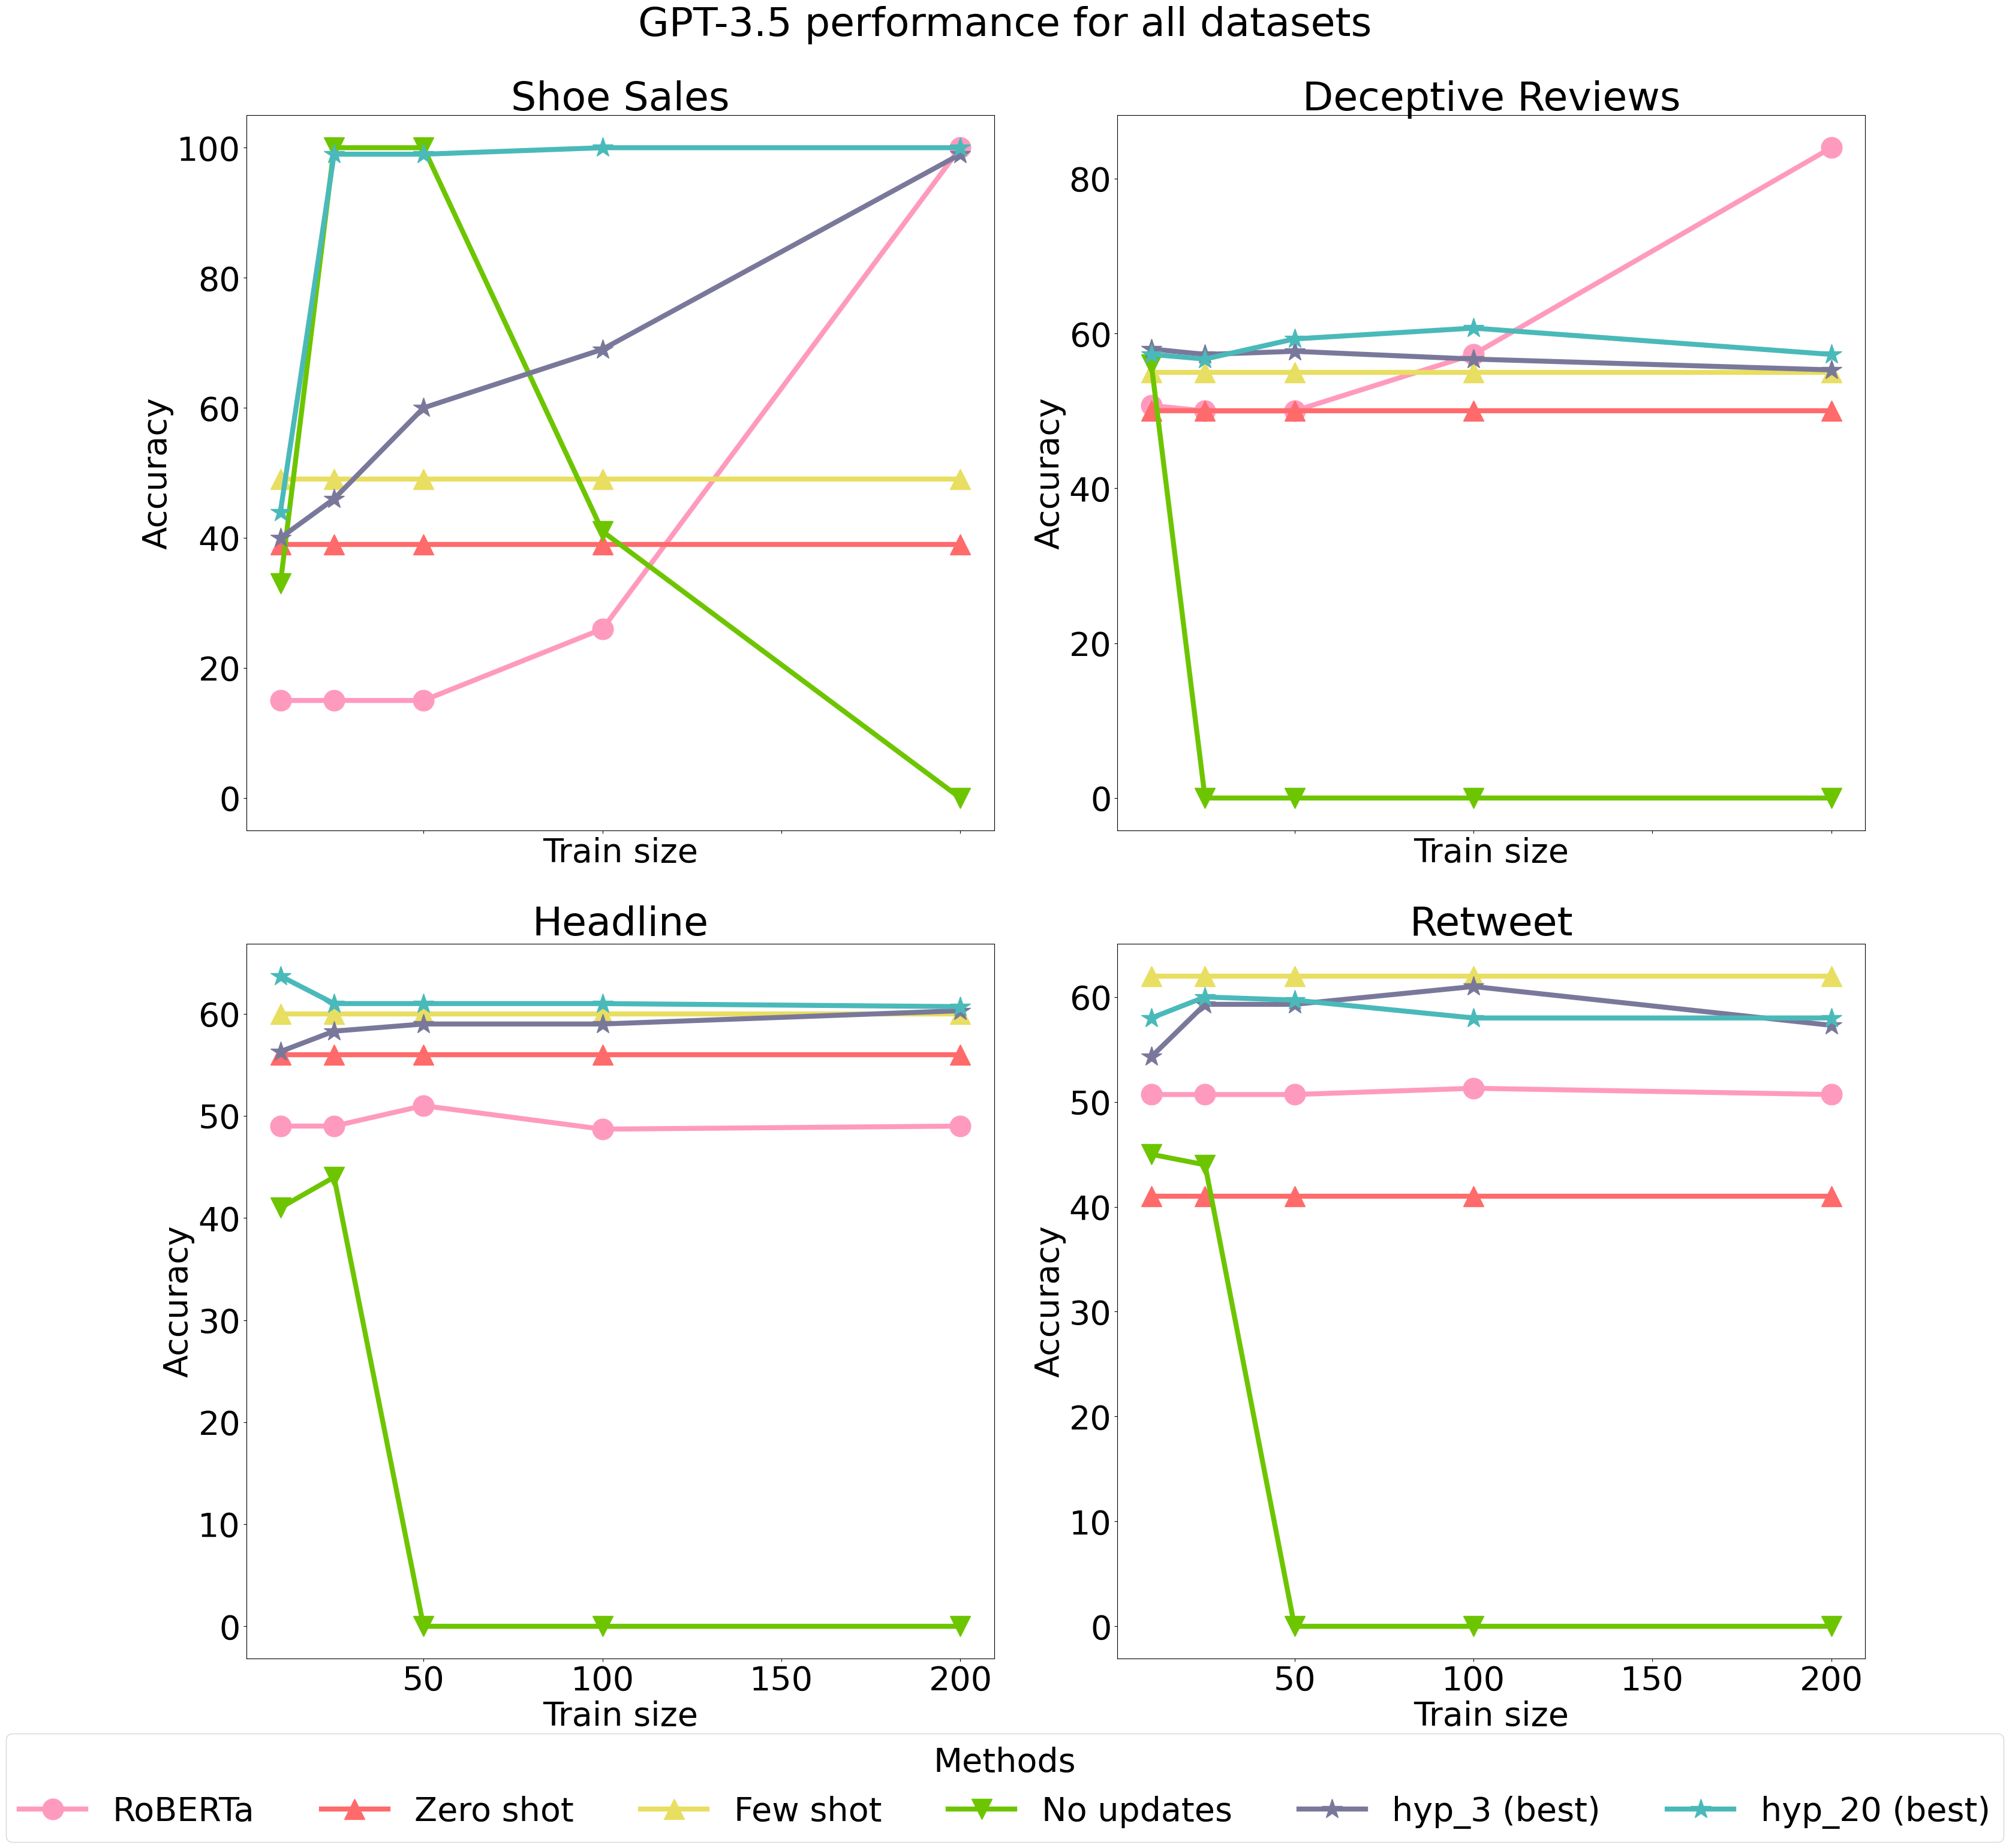

In [106]:
line_chart_by_model('turbo35_0613')

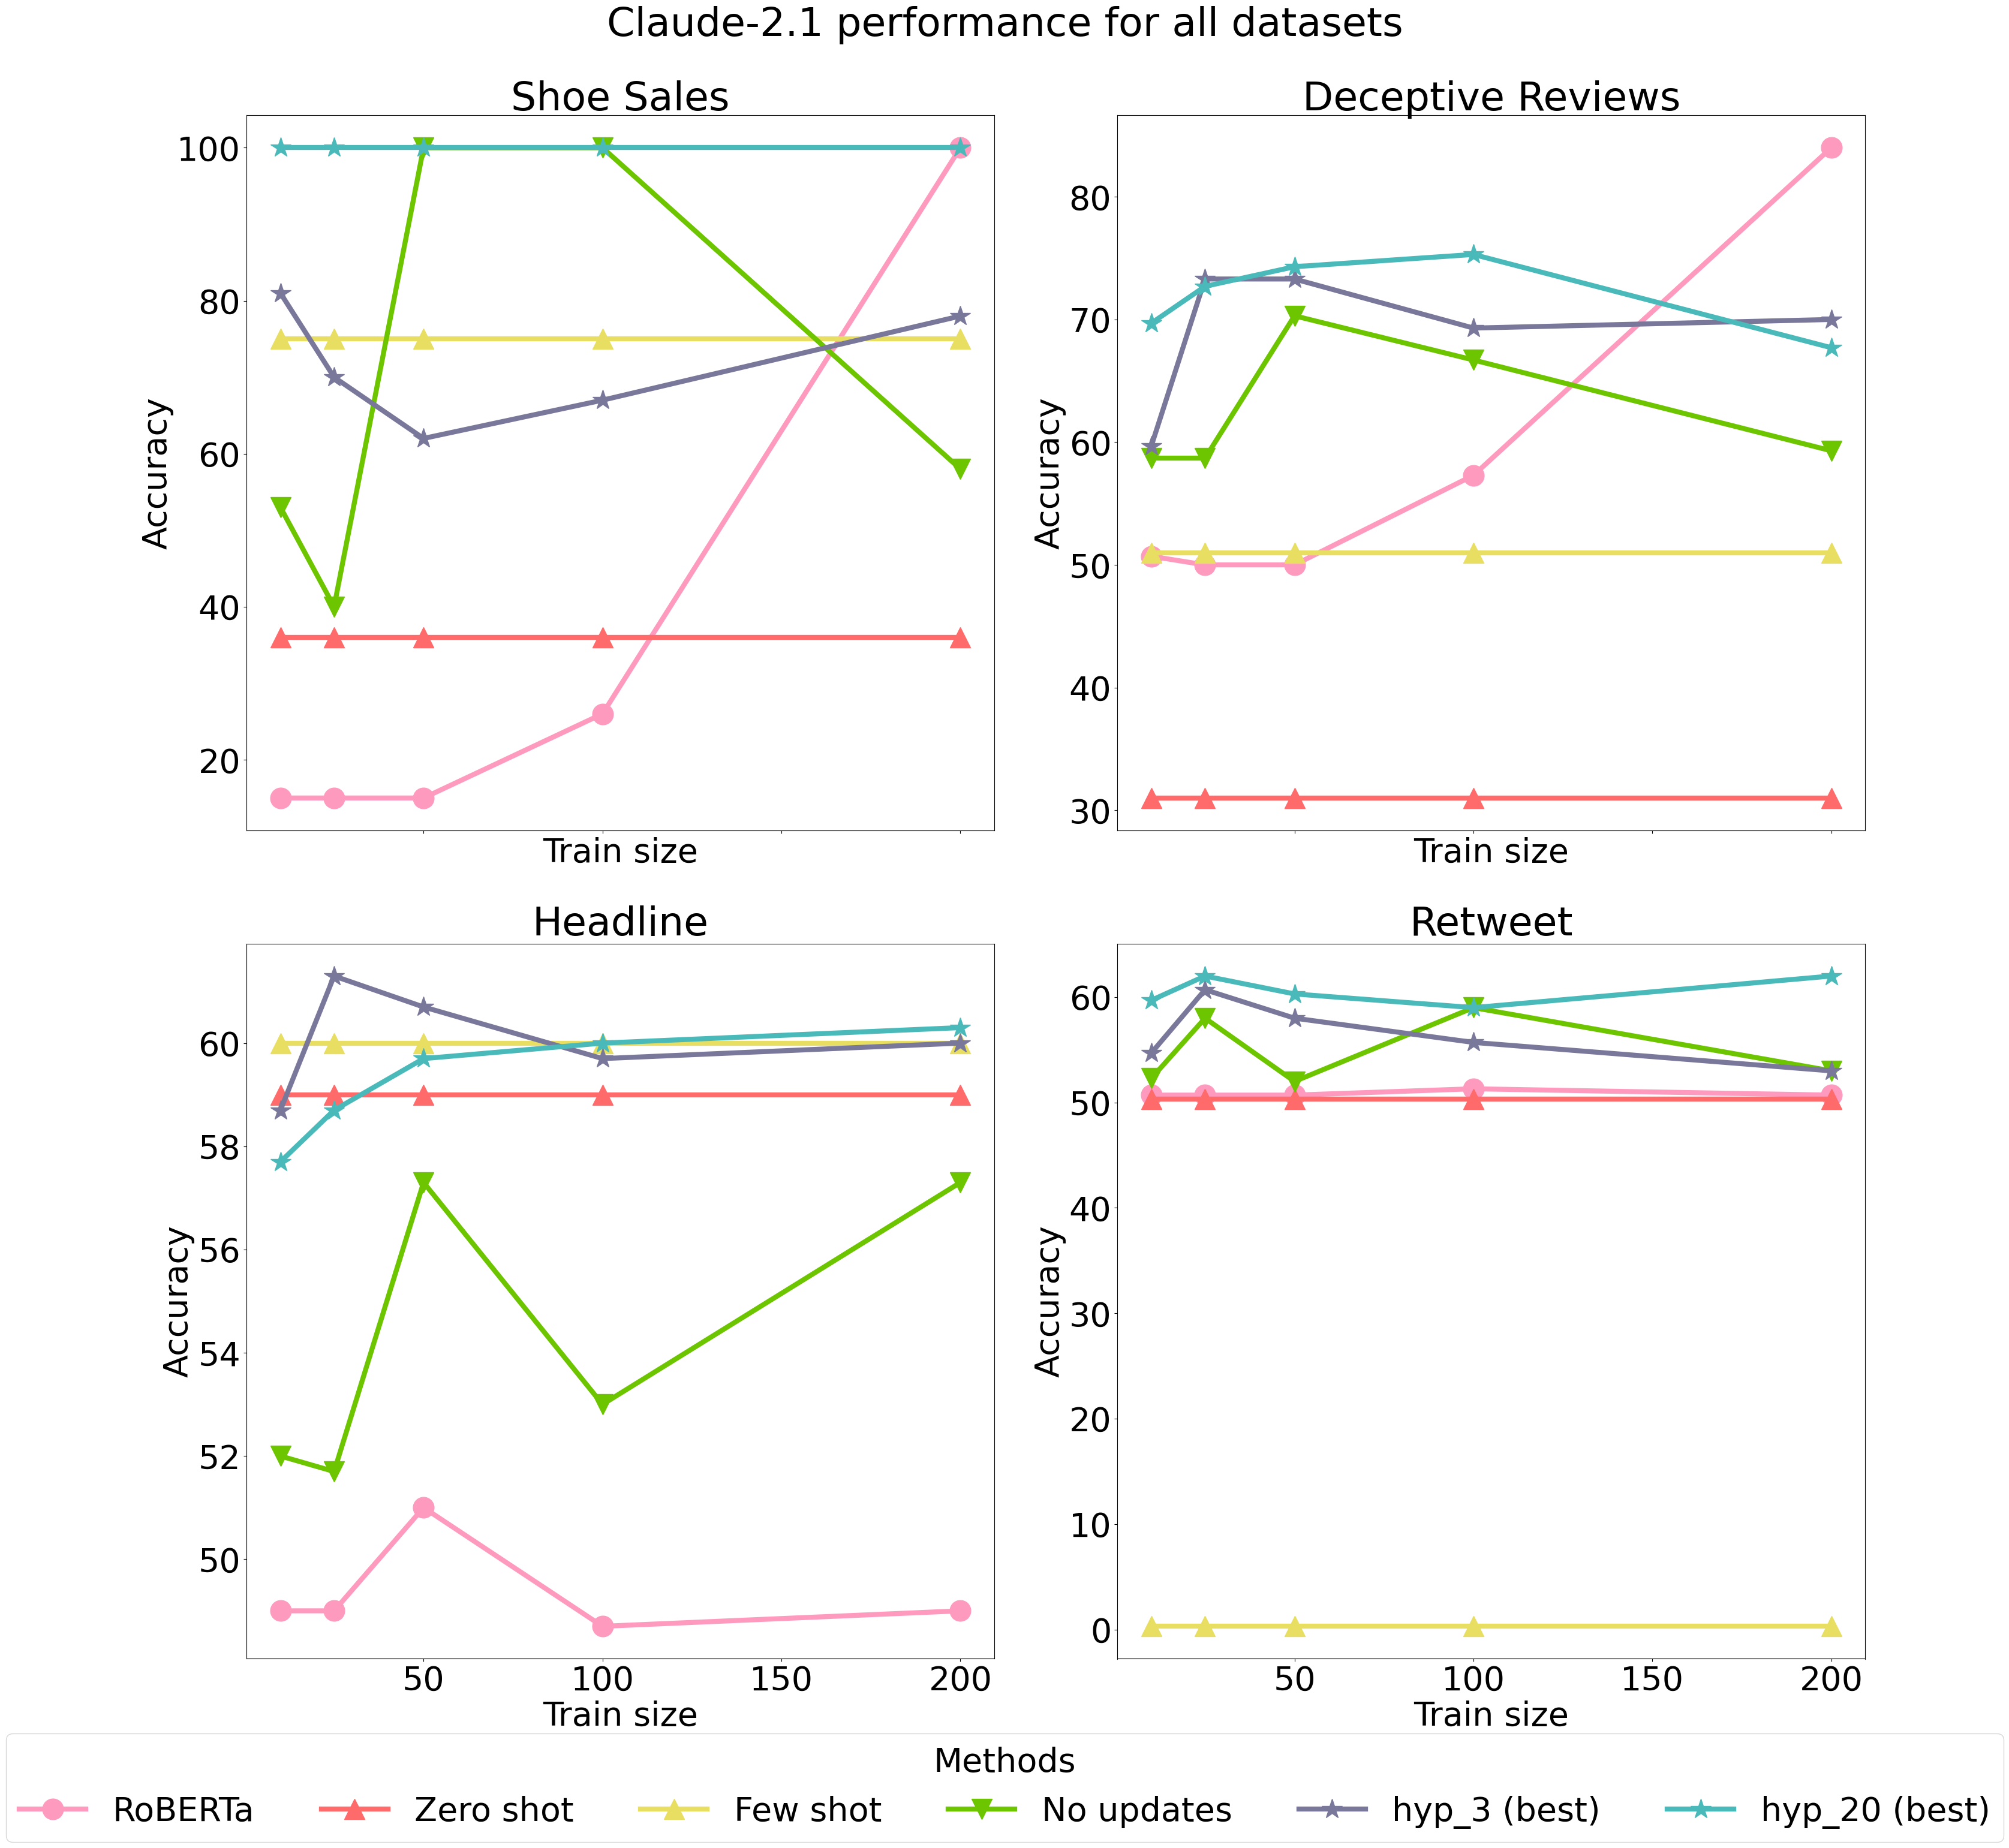

In [107]:
line_chart_by_model('claude_2')

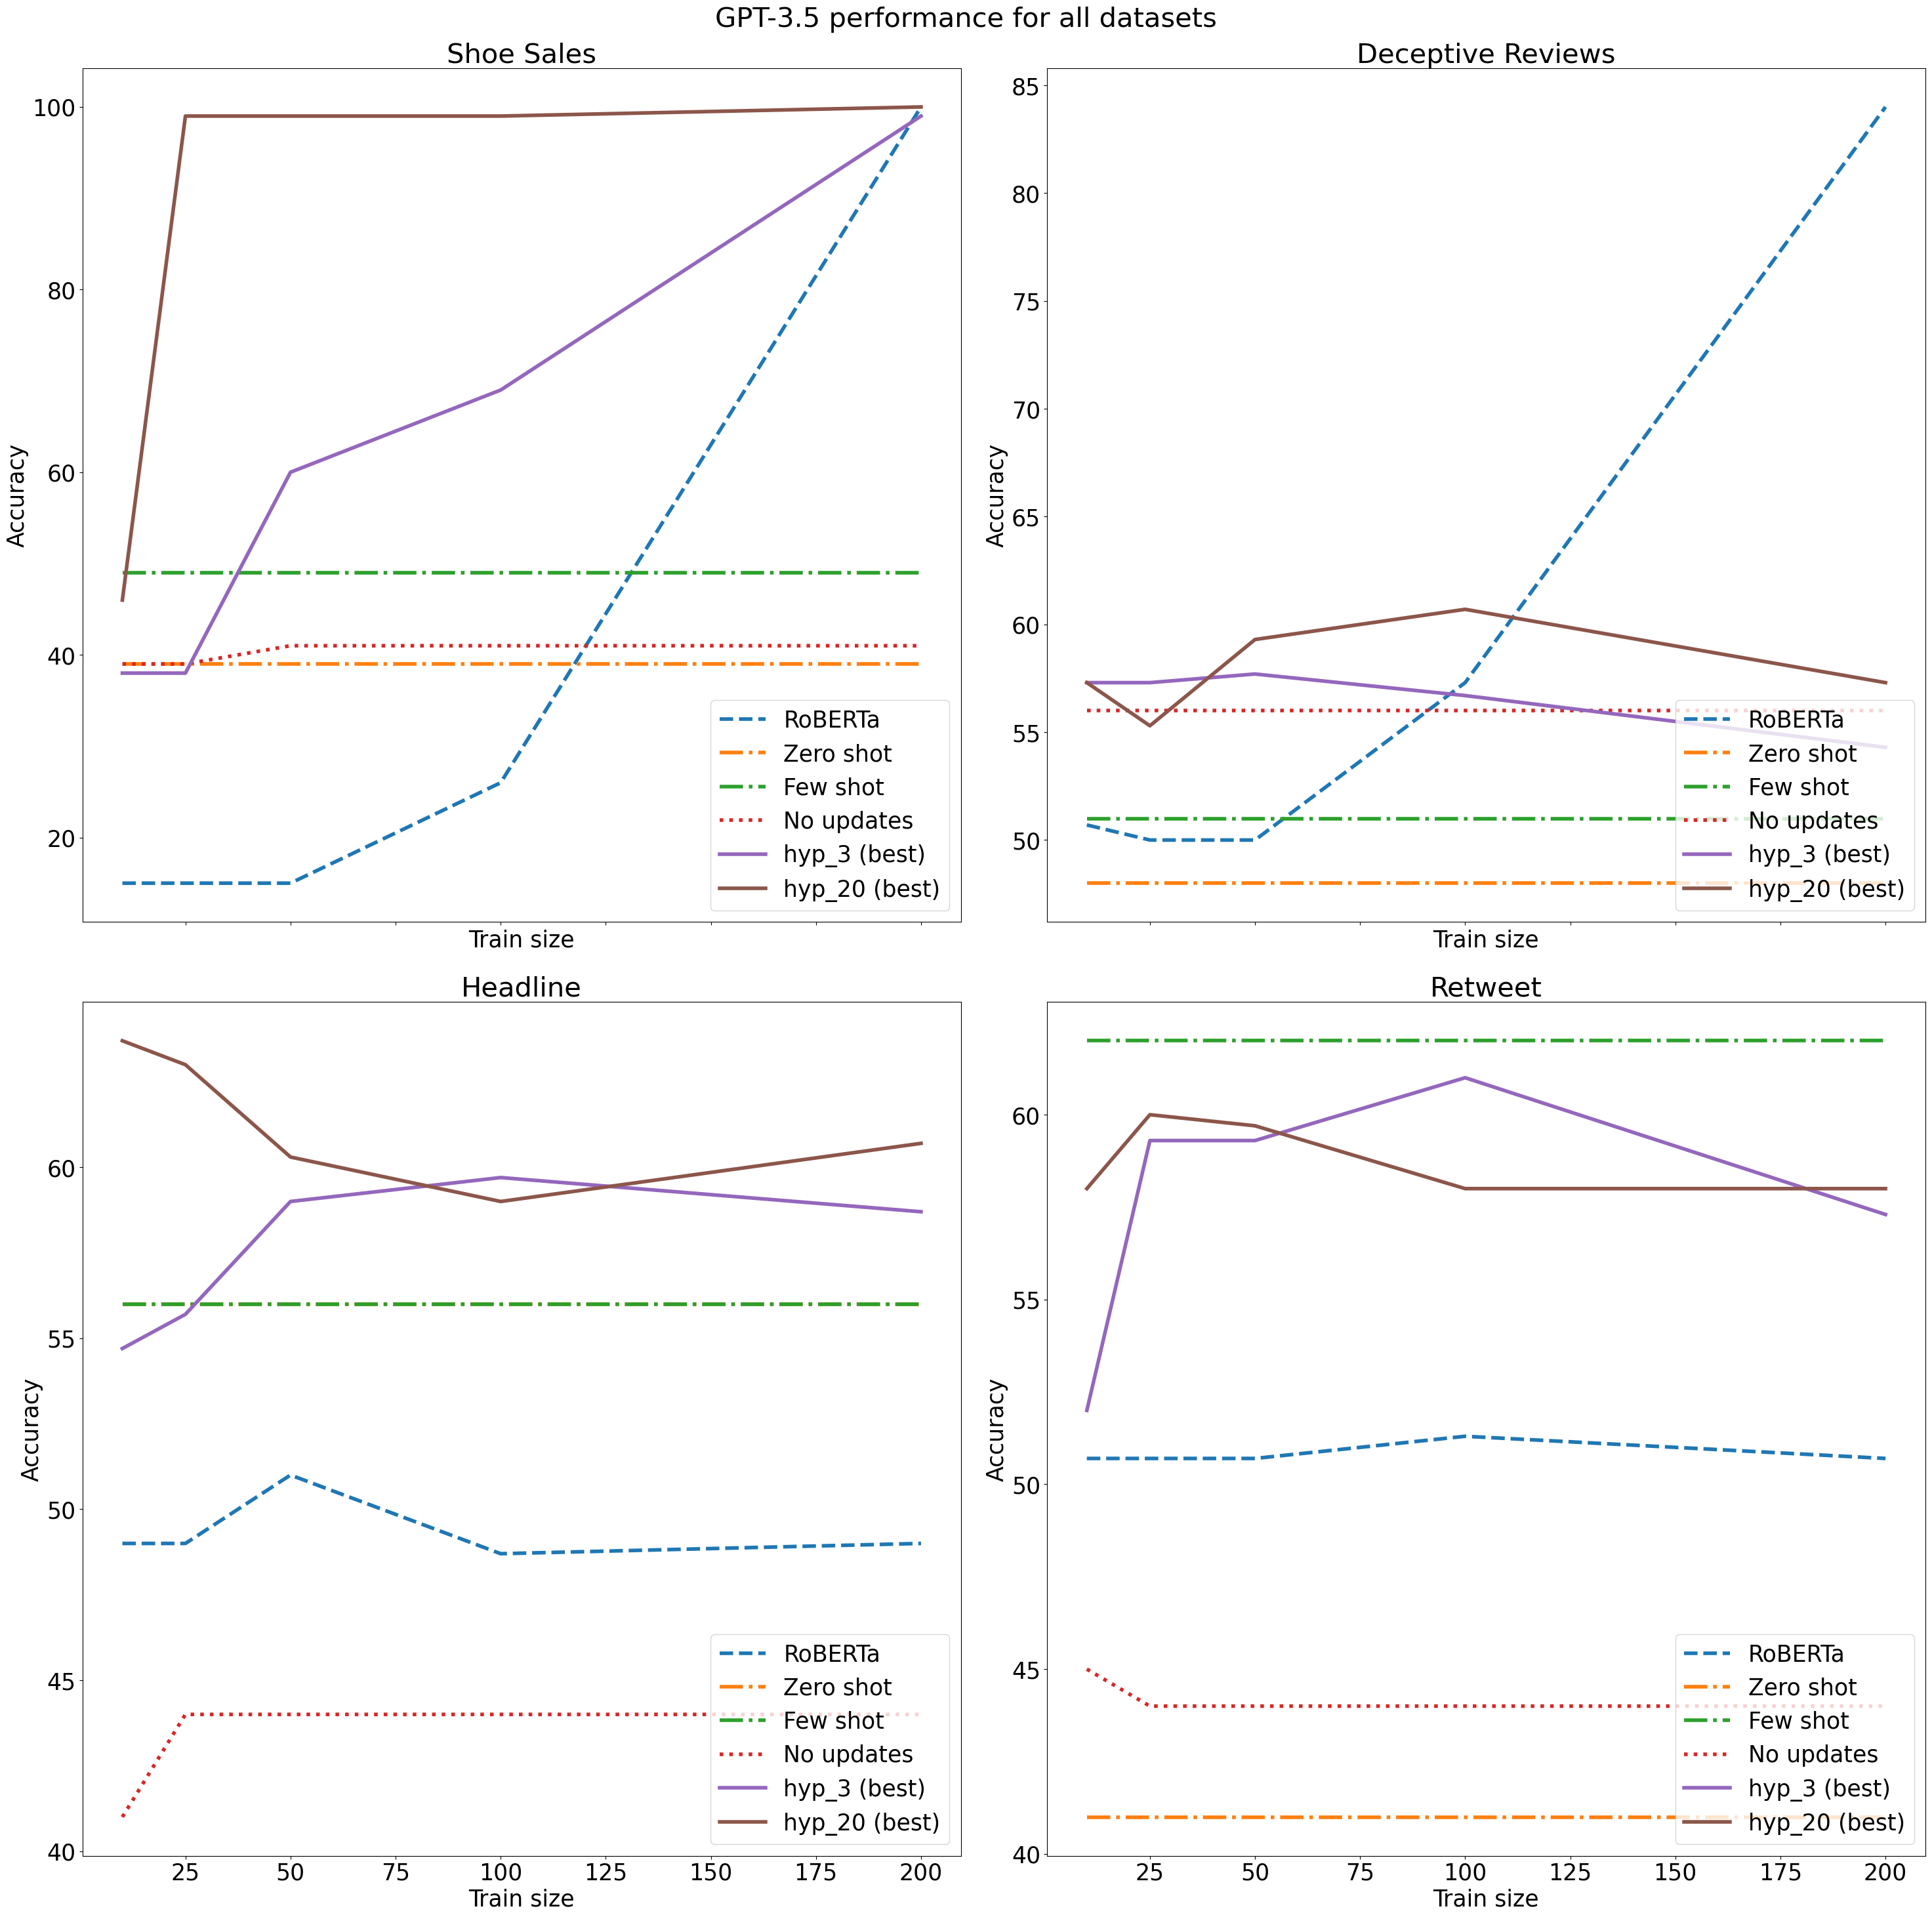

In [43]:
shoe = {
    "RoBERTa": [15.0, 15.0, 15.0, 26.0, 100.0],
    "Zero shot": [39.0]*5,
    "Few shot": [49.0]*5,
    "No updates": [39.0, 39.0, 41.0, 41.0, 41.0],
    "hyp_3 (best)": [38.0, 38.0, 60.0, 69.0, 99.0],
    "hyp_20 (best)": [46.0, 99.0, 99.0, 99.0, 100.0],
}

hotel = {
    "RoBERTa": [50.7, 50.0, 50.0, 57.3, 84.0],
    "Zero shot": [48.0]*5,
    "Few shot": [51.0]*5,
    "No updates": [56.0, 56.0, 56.0, 56.0, 56.0],
    "hyp_3 (best)": [57.3, 57.3, 57.7, 56.7, 54.3],
    "hyp_20 (best)": [57.3, 55.3, 59.3, 60.7, 57.3],
}

headline = {
    "RoBERTa": [49.0, 49.0, 51.0, 48.7, 49.0],
    "Zero shot": [56.0]*5,
    "Few shot": [56.0]*5,
    "No updates": [41.0, 44.0, 44.0, 44.0, 44.0],
    "hyp_3 (best)": [54.7, 55.7, 59.0, 59.7, 58.7],
    "hyp_20 (best)": [63.7, 63.0, 60.3, 59.0, 60.7],
}

retweet = {
    "RoBERTa": [50.7, 50.7, 50.7, 51.3, 50.7],
    "Zero shot": [41.0]*5,
    "Few shot": [62.0]*5,
    "No updates": [45.0, 44.0, 44.0, 44.0, 44.0],
    "hyp_3 (best)": [52.0, 59.3, 59.3, 61.0, 57.3],
    "hyp_20 (best)": [58.0, 60.0, 59.7, 58.0, 58.0],
}

all_results_list = [[shoe, hotel], [headline, retweet]]
dataset_names = [["Shoe Sales", "Deceptive Reviews"],["Headline", "Retweet"]]
train_sizes = [10, 25, 50, 100, 200]
line_styles = ['--','-.','-.',':','-','-']
font = {'size'   : 25}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(2, 2, figsize=(30,30), sharex=True)
for row in range(2):
    for col in range(2):
        data_to_plot = all_results_list[row][col]
        for idx, model in enumerate(data_to_plot.keys()):
            axes[row,col].plot(train_sizes,
                               data_to_plot[model],
                               label=model,
                               linewidth=4,
                               linestyle=line_styles[idx])
            axes[row,col].legend(loc='lower right')
            axes[row,col].set_ylabel("Accuracy")
            axes[row,col].set_xlabel("Train size")
            axes[row,col].set_title(dataset_names[row][col])

plt.suptitle("GPT-3.5 performance for all datasets")
plt.tight_layout()
plt.show()
fig.savefig(f'{code_repo_path}/figures/line_chart_GPT-3.5.png')